In [1]:
# IMPORT LIBRARIES
using Distributions, Turing, StatsPlots, Random, RDatasets

### Assignment 2: hierarchical models

In [2]:
# FETCH WARP BREAKS DATA SET
df = RDatasets.dataset("datasets", "warpbreaks")

,Breaks,Wool,Tension
,Int32,Cat…,Cat…
1,26,A,L
2,30,A,L
3,54,A,L
4,25,A,L
5,70,A,L
6,52,A,L
7,51,A,L
8,26,A,L
9,67,A,L


In [93]:
# DIVIDE BREAKS INTO GROUPS
breaks_a = df.Breaks[df.Wool .== "A"]
breaks_b = df.Breaks[df.Wool .== "B"]

27-element Array{Int32,1}:
 27
 14
 29
 19
 29
 31
 41
 20
 44
 42
 26
 19
 16
  ⋮
 21
 39
 29
 20
 21
 24
 17
 13
 15
 15
 16
 28

Infer the probability distribution of warp breaks for each of two wool types. Compare the results under separate and hierarchical models. Conduct two studies:

1. Ignore warp tension and compare wool types based on all experiments.
2. Account for warp tension in both the hierarchical model and the separate model.

#### Separate Model: Ignore wrap tension & Compare wool types based on all experiments

In [94]:
# WOOL SEPARATE MODEL OF TOTAL BREAKS FOR EACH TYPE
@model function wool_separate(breaks)    
    for i in eachindex(breaks)
        μ ~ Normal(20, 5)
        σ ~ Exponential(2)
        breaks[i] ~ Normal(μ, σ)
    end
end

wool_separate (generic function with 2 methods)

##### Breaks Data Groups A and B: Average and Std.

In [89]:
# AVERAGE BREAKS GROUP A
sum(breaks_a) / length(breaks_a)

31.037037037037038

In [90]:
# STD BREAKS GROUP A
std(breaks_a)

15.851429155372909

In [91]:
# AVERAGE BREAKS GROUP B
sum(breaks_b) / length(breaks_b)

25.25925925925926

In [92]:
# STD BREAKS GROUP B
std(breaks_b)

9.300920519342293

In [95]:
# CHAIN BREAKS OF TYPE A AND B
chn_a = sample(wool_separate(breaks_a), NUTS(), MCMCThreads(), 1000, 4)
chn_b = sample(wool_separate(breaks_b), NUTS(), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (t

LoadError: [91msyntax: missing comma or ) in argument list[39m

### Posterior of Breaks Types: A and B, under Separate Model, with out Wrap tension

##### Posterior Statistics of Groups A and B

In [213]:
print(
    "Posterior Statisitcs:\n\n",
    "Group A:\n",
    "μ Parameter:\n",
    "Average: ", sum(chn_a[:μ]) / length(chn_a[:μ]), "\n",
    "Std.: ", std(chn_a[:μ]),
    "\n\nσ Parameter:\n",
    "Average: ", sum(chn_a[:σ]) / length(chn_a[:σ]), "\n",
    "Std.: ", std(chn_a[:σ]), "\n\n",
    
    "Group B:\n",
    "μ Parameter:\n",
    "Average: ", sum(chn_b[:μ]) / length(chn_b[:μ]), "\n",
    "Std.: ", std(chn_b[:μ]),
    "\n\nσ Parameter:\n",
    "Average: ", sum(chn_b[:σ]) / length(chn_b[:σ]), "\n",
    "Std.: ", std(chn_b[:σ]), "\n\n"
)

Posterior Statisitcs:

Group A:
μ Parameter:
Average: 22.842257514346528
Std.: 0.850177680750431

σ Parameter:
Average: 8.538785049228045
Std.: 0.4801833192034901

Group B:
μ Parameter:
Average: 22.276470497814863
Std.: 0.7254322162647939

σ Parameter:
Average: 5.72835090727698
Std.: 0.3823083171873714



##### Posterior Plotting of Groups A and B

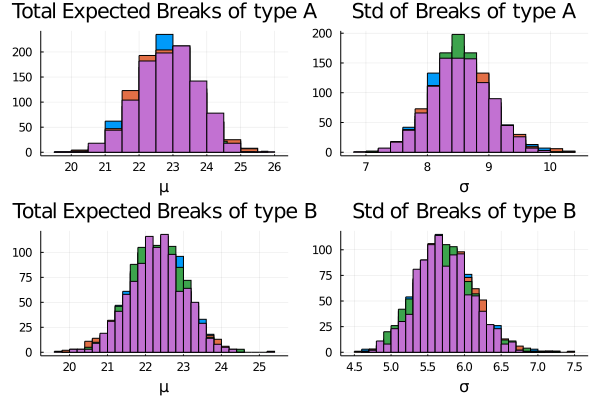

In [83]:
let
    plot(layout=4)
    histogram!(chn_a[:μ], xlabel="μ", label=missing,  subplot=1, title="Total Expected Breaks of type A")
    histogram!(chn_a[:σ], xlabel="σ", label=missing, subplot=2, title="Std of Breaks of type A")
    histogram!(chn_b[:μ], xlabel="μ", label=missing,  subplot=3, title="Total Expected Breaks of type B")
    histogram!(chn_b[:σ], xlabel="σ", label=missing, subplot=4, title="Std of Breaks of type B")
end

In [161]:
# WOOL SEPARATE MODEL OF TOTAL BREAKS FOR EACH TYPE
@model function wool_hirerchial(breaks_groups)
    τ ~ LogNormal(0, 10)  # Groups difference factor
    
    μ ~ Normal(20, 5)  # Breaks total average
    σ ~ LogNormal(5, 1)  # Breaks total std.
    η ~ MvNormal([0, 0], 1)  # Group difference
    
    θ = μ .+ τ .* η  # Constructed Hyperparameter

    for i in eachindex(breaks_groups)
        for j in eachindex(breaks_groups[i])
            breaks_groups[i][j] ~ Normal(θ[i], σ)
        end
    end
end

wool_hirerchial (generic function with 1 method)

In [162]:
# CHAIN BREAKS HIRERCHIAL
chn = sample(wool_hirerchial([breaks_a, breaks_b]), NUTS(), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (tr

Chains MCMC chain (1000×17×4 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = η[1], η[2], μ, σ, τ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

        η[1]    0.0982    1.0280     0.0163    0.0431    580.9806    1.0057
        η[2]   -0.0562    1.0114     0.0160    0.0357   1167.0115    1.0050
           μ   27.0896    1.9289     0.0305    0.1128    234.1760    1.0147
           σ   13.8098    1.3901     0.0220    0.0544    811.8994    1.0033
           τ    0.6561    1.7345     0.0274    0.1163    202.0984    1.0084

Quantiles
  parameters      2.5%     25.0%    

### Posterior of Wool Breaks, under Hirerchial Model, with out Wrap tension

##### Posterior Statistics of hirarchial model results

In [215]:
# POSTERIOR CONSTRUCTED HYPYERPARAMETER VALUE
θ = mean(chn[:μ]) .+ mean(chn[:τ]) .* mean(Array(group(chn, :η))) # Constructed Hyperparameter
θ_ = std(chn[:μ]) .+ std(chn[:τ]) .* std(Array(group(chn, :η))) # Constructed Hyperparameter

# DIVIDE η PARAMETER TO GROUP A AND GROUP B
η = Array(group(chn, :η)) 

η1 = []  # GROUP A
η2 = []  # GROUP B

for i in eachindex(η)
    if i % 2 == 0
        push!(η1, η[i])
    else
        push!(η2, η[i])
    end
end

In [212]:
print(
    "Posterior Statisitcs:\n\n",
    "θ Hyperparameter:\n",
    "Average: ", θ, "\n",
    "Std.: ", θ_,
    
    "\n\nσ Parameter:\n",
    "Average: ", sum(chn[:σ]) / length(chn[:σ]), "\n",
    "Std.: ", std(chn[:σ]), "\n\n",
    
    "τ Parameter:\n",
    "Average: ", sum(chn[:τ]) / length(chn[:τ]), "\n",
    "Std.: ", std(chn[:τ]),
    
    "\n\nμ Parameter:\n",
    "Average: ", sum(chn[:μ]) / length(chn[:μ]), "\n",
    "Std.: ", std(chn[:μ]),
    
    "\n\nη Parameter (Group A):\n",
    "Average: ", sum(η1) / length(η1), "\n",
    "Std.: ", std(η1),
    
      "\n\nη Parameter (Group B):\n",
    "Average: ", sum(η2) / length(η2), "\n",
    "Std.: ", std(η2),
)

Posterior Statisitcs:

θ Hyperparameter:
Average: 27.103439989488702
Std.: 3.702620243368424

σ Parameter:
Average: 13.809818223689954
Std.: 1.3901165382741987

τ Parameter:
Average: 0.6561494261205939
Std.: 1.7345490192384758

μ Parameter:
Average: 27.089638256068625
Std.: 1.9289141361057731

η Parameter (Group A):
Average: 0.02785646943044065
Std.: 1.0284898518361836

η Parameter (Group B):
Average: 0.014212403514180964
Std.: 1.0167081306121706

##### Posterior Plotting of the hirerchial model results

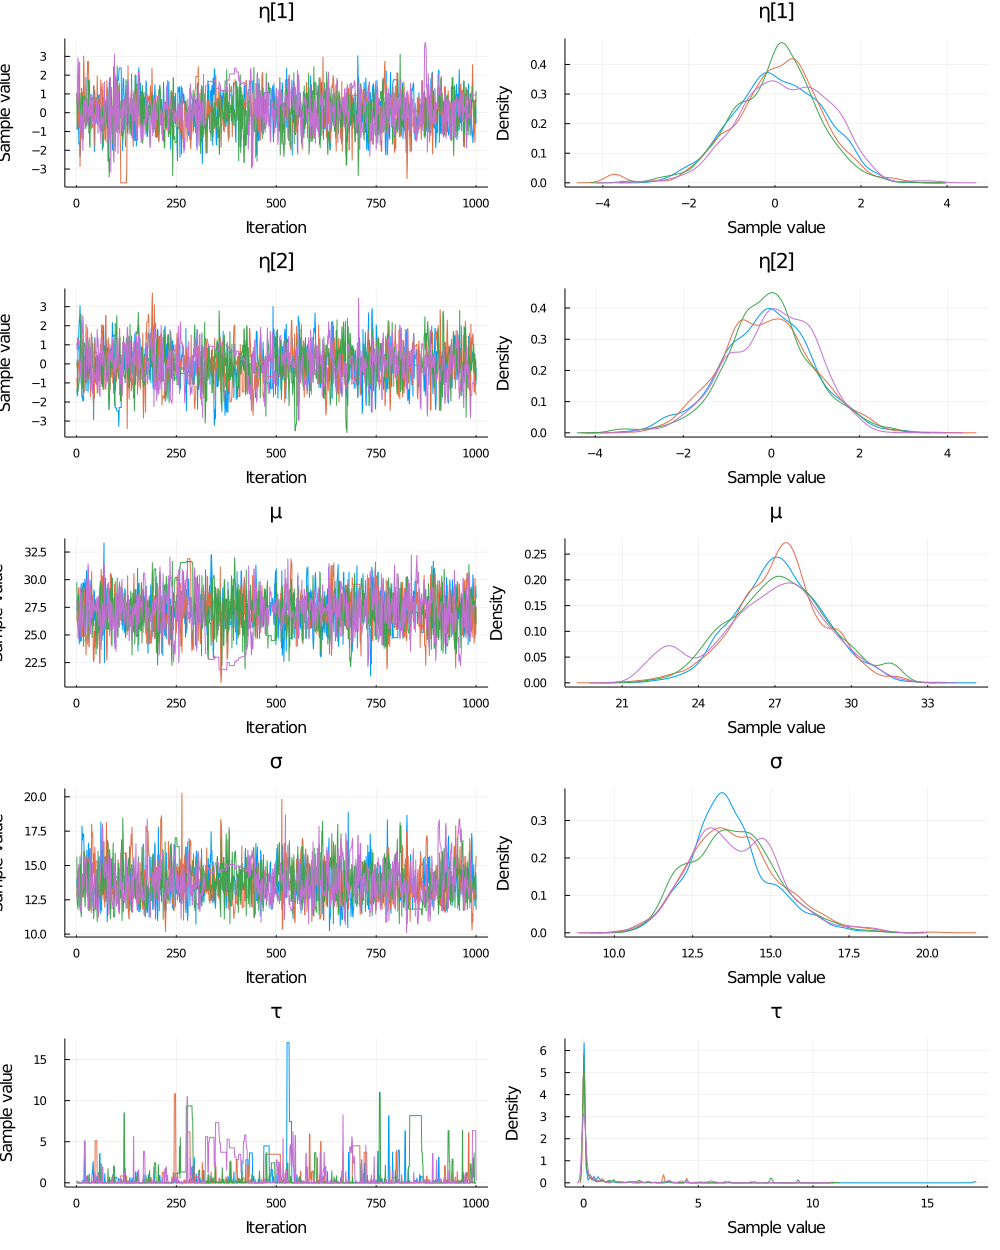

In [163]:
# PLOT CHAIN PARAMETERS
plot(chn)